# IAM Model Validation
The purpose of this notebook is to validate the use of new or current IAM models through multiple steps of analysis

<li><b>1. Import data from DuraMAT</b></li>
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [1]:
#import necessary packages and set default formatting for plots
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import pvlib
import pvanalytics
import sklearn.metrics
import scipy
from matplotlib.lines import Line2D
from tabulate import tabulate

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

## 1. Import Data

In [2]:
#read in data from duramat data hub directly
df = pd.read_excel('pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx', sheet_name='S2')
#df = pd.read_excel(https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,
#                   sheet_name='S2'

#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

#apply the filters that are included in the data & replacing any 0 with nan so they dont affect error metrics
#dropping nans helps keep size down so operations run more quickly and smoothly
df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data

In [3]:
#Defining constants and values that are consistent across all calculations
#we are using S2 from the data, which is the Candian Solar Monocrystalline 275W module
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 'iam30': 1.0002, 'iam40':0.9984, 
          'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 'iam80':0.6778, 'iam85': 0.4351,
         'U0': 28.825, 'U1': 4.452, 'NOCT': 45, 'Unit Mass': 11.119, 'Area':1.621, 'Pmp' : 275, 'Gamma Pmp': -0.0041, 'Alpha Isc':0.0033,
          'Beta Voc': -0.1178, 'Cell Type':'monoSi', 'Cells in Series':60}
module = pd.Series(module)

#Running solar position calculations
spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
df['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['AOI'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'],solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
df['Airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = df['dni_extra'])

#The 'true' values that the IAM models will be compared to are the interpolated IAMs found using module-specific measured data
ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
            module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
df['IAM - Interp'] = pvlib.iam.interp(aoi=df['AOI'],theta_ref=ref_thetas,iam_ref=ref_iams, method='linear' )
spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925


## 3. Run the model or import the results to be validated

In [4]:
#Either run a model in this notebook or import the results into the column name below

#run model here
df['Modeled IAM'] = pvlib.iam.physical(aoi=df['AOI'])

# or import model results here. Make sure timestamps line up and are middle-of-hour
# df['Modeled IAM'] = pd.read_excel('results.xlsx')

#specify a model name for use in analysis and plotting
model_name = 'Physical'

In [5]:
#this cell checks for unphysical IAM & AOI values and checks that AOI is monotonically decreasing as AOI is increasing
for i in np.arange(len(df)):
    if (df['Modeled IAM'][i] > 1) & (df['AOI'][i] != 0):
        print('AOI not zero when IAM = 1 at: ',str(df.iloc[i,:]['TmStamp']))
    elif (df['Modeled IAM'][i] != 0) & (df['AOI'][i] == 90):
        print('AOI not one when IAM = 0 at: ',str(df.iloc[i,:]['TmStamp']))
for p in np.arange(len(df)-1):
    if ((df.sort_values('AOI')['Modeled IAM'][p] - df.sort_values('AOI')['Modeled IAM'][p+1]) < 0):
        print('IAM is not monotonically decreasing as AOI is increasing at',str(df.iloc[p,:]['TmStamp']))

### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious errors like time shifts or magnitude differences

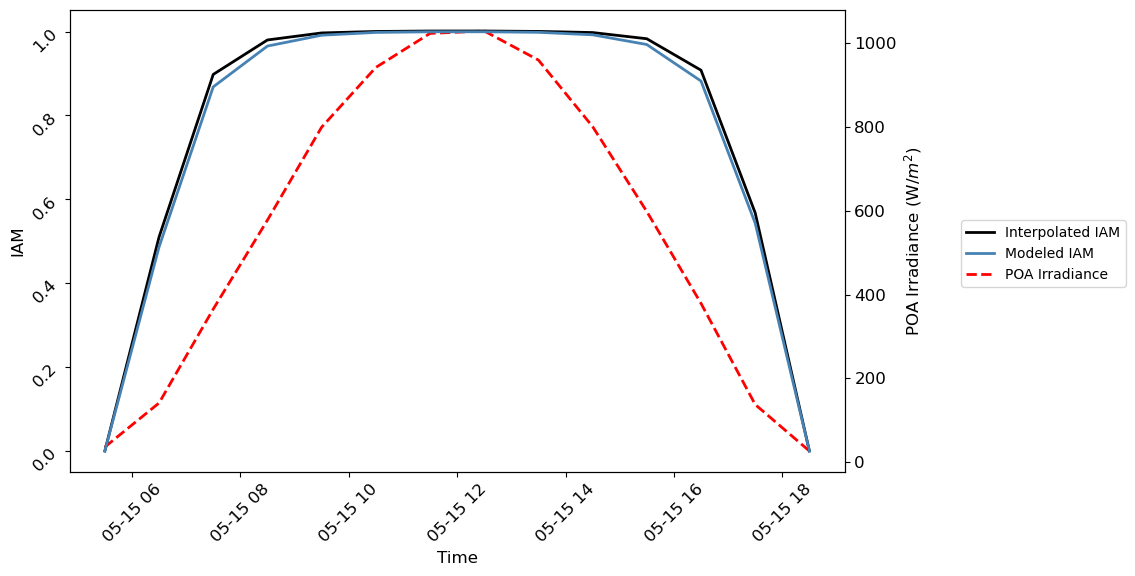

In [6]:
#diurnal plot
day = 15
month = 5

fig, ax = plt.subplots()
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['IAM - Interp'], linewidth=2, color='black', zorder=5.5)
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled IAM'], linewidth=2, color='steelblue', zorder=5.5)

ax.tick_params(labelrotation = 45)
ax.set_ylabel('IAM')
ax.set_xlabel('Time')
ax2 = ax.twinx()
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured front POA irradiance (W/m2)'], linewidth=2,linestyle='dashed',color='red',zorder=2.5)
ax2.set_ylabel('POA Irradiance (W/$m^2$)')
plt.grid(False)
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

line_1 = Line2D([0], [0], color='black', linewidth=2, linestyle='-',label='Interpolated IAM')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Modeled IAM')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='POA Irradiance')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.15, 0.4],handles=lines)

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall NMBE, MBE, RMSE, NRMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Normalized Mean Bias Error (NMBE) - shows the estimation bias of the model
###                 $100 * \frac{V_{modeled} - V_{measured}}{V_{measured}}$


#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [7]:
df['BE'] = (df['Modeled IAM'] - df['IAM - Interp'])
mbe = df['BE'].mean()
rmse = sklearn.metrics.mean_squared_error(df.dropna()['Modeled IAM'],df.dropna()['IAM - Interp'], squared=False)

d = [ ['MBE', str(round(mbe,3))],  ['RMSE',str(round(rmse,3))]]
print (tabulate(d, headers=["Metric", "Value"]))

Metric      Value
--------  -------
MBE        -0.011
RMSE        0.016


Text(0.5, 1.0, 'Measured vs Modeled Values')

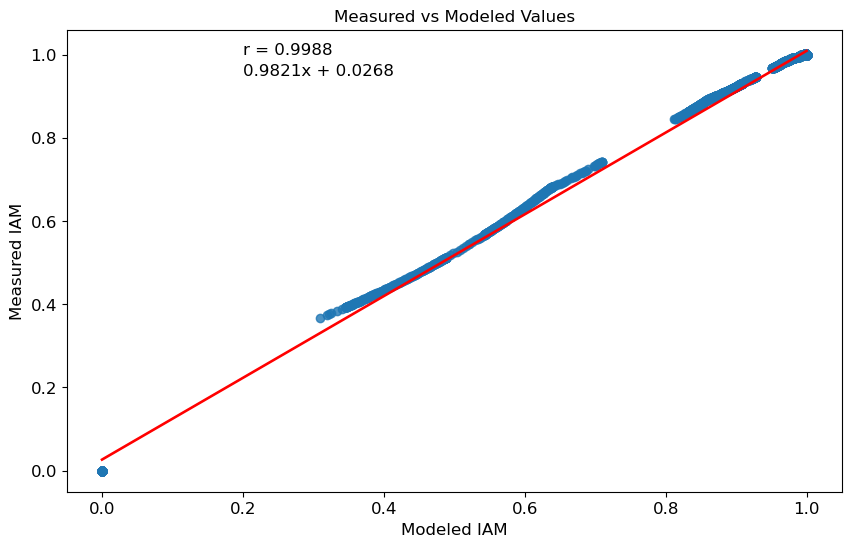

In [8]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled IAM'], y = df.dropna()['IAM - Interp'])
sns.regplot(x = df['Modeled IAM'], y = df['IAM - Interp'], line_kws={'color':'red'})

plt.ylabel('Measured IAM')
plt.xlabel('Modeled IAM')
plt.text(0.2, 1.0, s = ("r = "+str(round(r,4))))
plt.text(0.2, 0.95, s = (str(round(slope,4))+'x + '+str(round(intercept,4))))
plt.title('Measured vs Modeled Values')

#The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

Text(0.5, 1.0, 'IAM vs AOI')

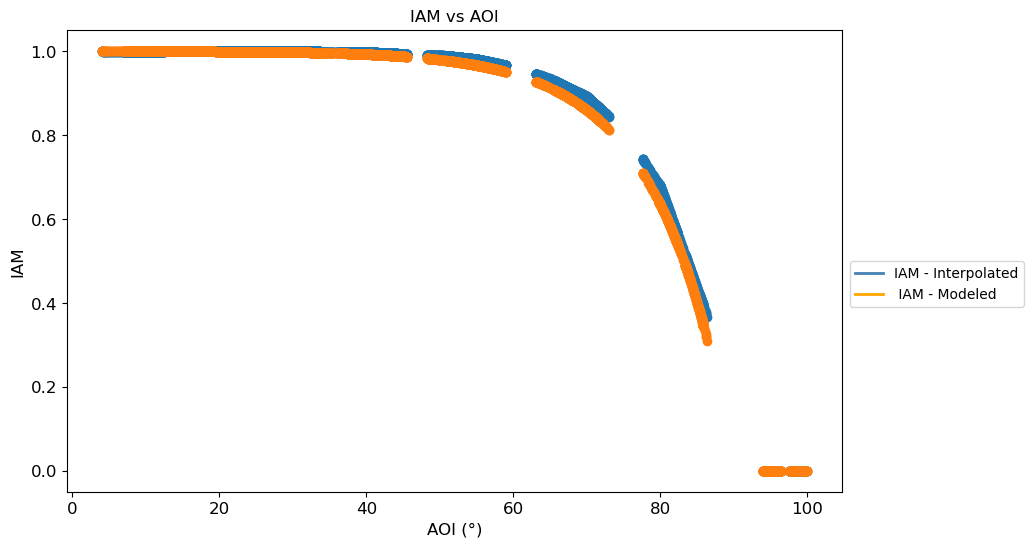

In [9]:
#iam vs aoi curve
plt.scatter(x=df['AOI'], y=df['IAM - Interp'])
plt.scatter(x=df['AOI'], y=df['Modeled IAM'])
plt.ylabel('IAM')
plt.xlabel('AOI (°)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=('IAM - Interpolated'))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label= ' IAM - Modeled')
lines = [line_1,line_3]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('IAM vs AOI')

### Energy Yield Estimates
In order to see the impact of the IAM on overall energy output, we will run two performance models and used our measured (interpolate) values and the modeled IAM values and compare these outputs to see how they vary

In [10]:
#first we need poa components to use in calculating effective irradiance
efdf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=df['Zenith'], solar_azimuth=df['Azimuth'],dni=df['DNI (W/m2)'],
        ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=df['dni_extra'], model ='perez', model_perez='albuquerque1988')

In [11]:
#use the interpolated & modeled IAM to get two different effective irradiance values, we will do further analysis on these in a bit
df['Effective Irradiance - Interp'] = ((efdf['poa_direct'] *  (df['IAM - Interp'])) + efdf['poa_diffuse'])
df['Effective Irradiance - Model IAM'] = ((efdf['poa_direct'] * (df['Modeled IAM'])) + efdf['poa_diffuse'])

df['Eff Irr - Model IAM NBE'] = 100 * (df['Effective Irradiance - Model IAM']-df['Effective Irradiance - Interp'])/(df['Effective Irradiance - Interp'])

In [12]:
#using effective irradiance with interpolated IAM to estimate energy
df['DC Power - Meas IAM'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance - Interp'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#using effective irradiance with modeled IAM to estimate energy
df['DC Power - Model IAM'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance - Model IAM'] , 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#find overall % diff for annual energy
print('With interpolated IAM, predicted annual energy is', round(df['DC Power - Meas IAM'].sum()/1000,3),
      'kWh and with modeled IAM, predicted annual energy is', round(df['DC Power - Model IAM'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using interpolated vs modeled IAM is ', 
      round(((df['DC Power - Model IAM'].sum()-df['DC Power - Meas IAM'].sum())/df['DC Power - Meas IAM'].sum())*100,3),'%')

With interpolated IAM, predicted annual energy is 6705.343 kWh and with modeled IAM, predicted annual energy is 6673.457 kWh
The % difference in energy estimate when using interpolated vs modeled IAM is  -0.476 %


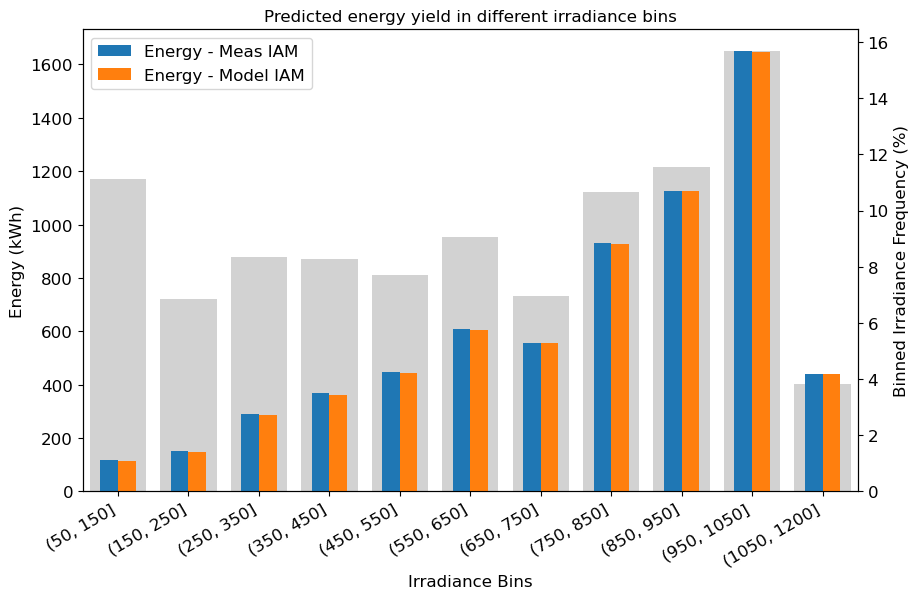

In [13]:
#we can plot the energy produced in each bin of irradiance and see where the largest differences are when using modeled/measured POA

df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

bins['Energy - Model IAM'] = df.groupby('Irradiance Bins').sum()['DC Power - Model IAM']/1000
bins['Energy - Meas IAM'] = df.groupby('Irradiance Bins').sum()['DC Power - Meas IAM']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Meas IAM", "Energy - Model IAM"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)


plt.title('Predicted energy yield in different irradiance bins')
plt.show()


### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
### $V_{modeled} - V_{measured}$

Because of the sensitivity in taking differences in fractional values, we will be using the calcualted effective irradiances to analyze the residuals. All inputs were identical with the exception of the IAM, so any differences between the two can be attributed directly to IAM

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

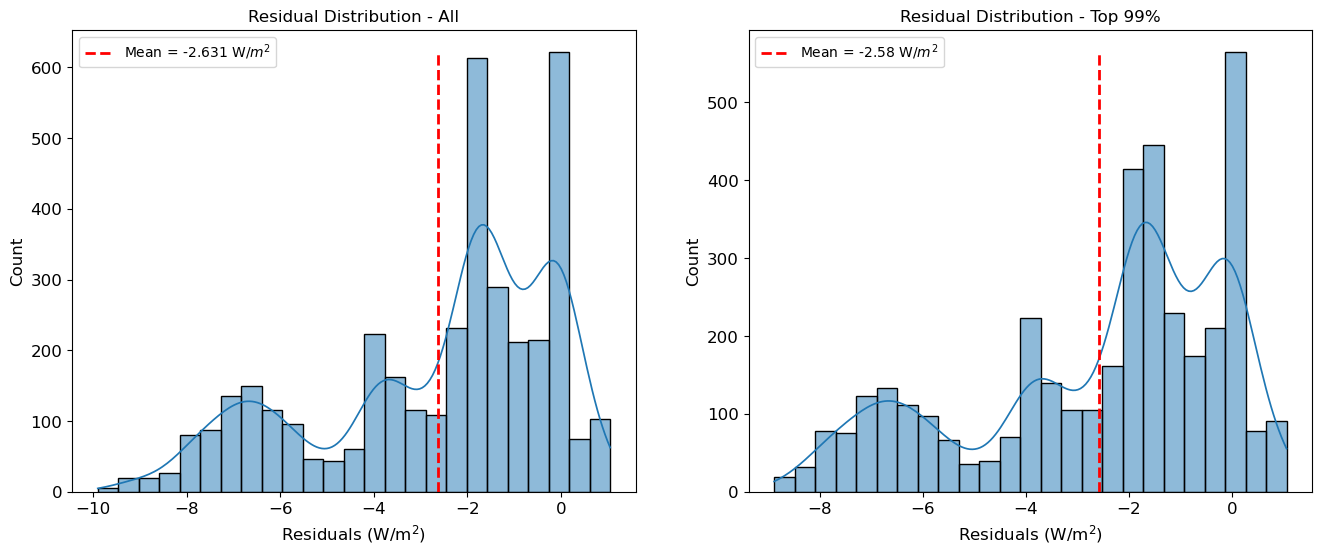

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

df['Residuals'] = (df['Effective Irradiance - Model IAM'] - df['Effective Irradiance - Interp'])
hsp = sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
h = []
for rectangle in hsp.patches:
    h.append(rectangle.get_height())
ax1.vlines(x=df['Residuals'].mean(), ymin=0, ymax=max(h), linewidth=2, color='red',linestyles='--')
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (W/m$^2$)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W/$m^2$'))]
ax1.legend(prop=dict(size='small'),handles=line_4)

#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
hsp = sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
h = []
for rectangle in hsp.patches:
    h.append(rectangle.get_height())
ax2.vlines(x=df['resid_trim'].mean(), ymin=0, ymax=max(h), linewidth=2, color='red',linestyles='--')
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (W/m$^2$)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W/$m^2$'))]
ax2.legend(prop=dict(size='small'),handles=line_4)

Text(764.6928104575164, 0.5, 'Model Residuals ($W/m^2$)')

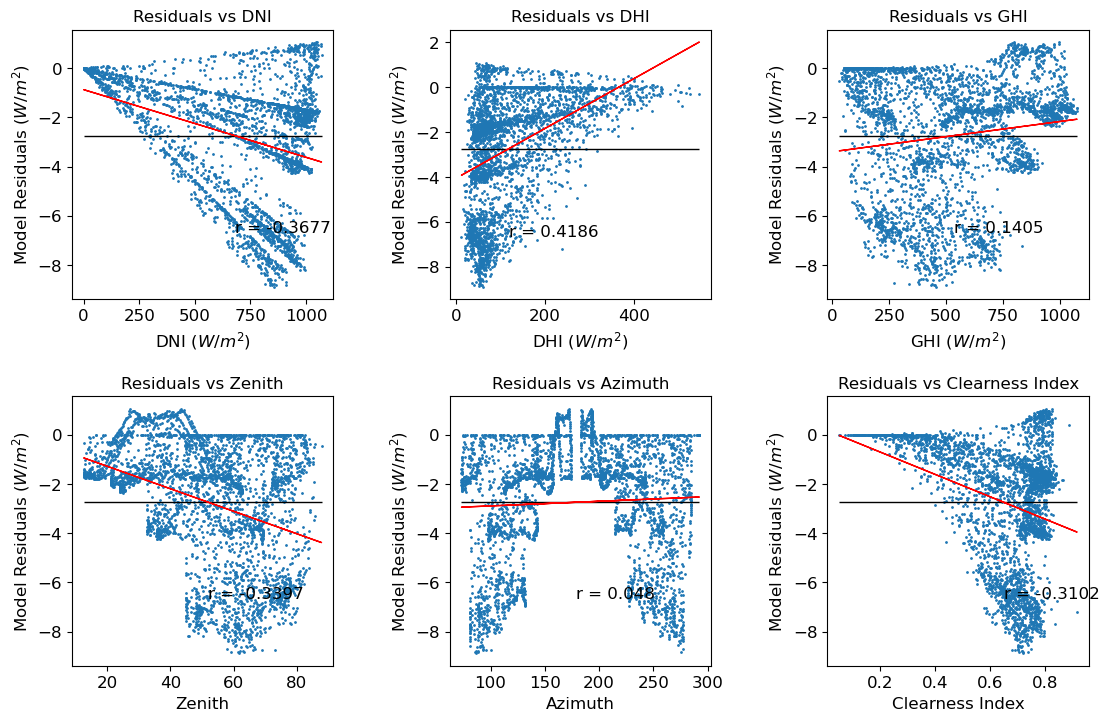

In [15]:
#plot residuals against some inputs

fig, axs = plt.subplots(2, 3,figsize=(12,8))
fig.tight_layout(pad=4.0)
# y = df['Residuals']
# y_avg = df['Residuals'].mean()
# y_med = df['Residuals'].median()
df = df.dropna()
y = df['resid_trim']
y_avg =  df['resid_trim'].mean()
y_med =  df['resid_trim'].median()
x = df['DNI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 0].scatter(x, y, s=1)
axs[0, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[0, 0].plot(x, p(x), linewidth=1, color='red')
axs[0, 0].set_title('Residuals vs DNI')
axs[0, 0].set_xlabel('DNI ($W/m^2$)')
axs[0, 0].set_ylabel('Model Residuals ($W/m^2$)')
x = df['DHI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 1].scatter(x, y, s=1)
axs[0, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[0, 1].plot(x, p(x), linewidth=1, color='red')
axs[0, 1].set_title('Residuals vs DHI')
axs[0, 1].set_xlabel('DHI ($W/m^2$)')
axs[0, 1].set_ylabel('Model Residuals ($W/m^2$)')
x = df['GHI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 2].scatter(x, y, s=1)
axs[0, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[0, 2].plot(x, p(x), linewidth=1, color='red')
axs[0, 2].set_title('Residuals vs GHI')
axs[0, 2].set_xlabel('GHI ($W/m^2$)')
axs[0, 2].set_ylabel('Model Residuals ($W/m^2$)')
x = df['Zenith']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 0].scatter(x, y, s=1)
axs[1, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[1, 0].plot(x, p(x), linewidth=1, color='red')
axs[1, 0].set_title('Residuals vs Zenith')
axs[1, 0].set_xlabel('Zenith')
axs[1, 0].set_ylabel('Model Residuals ($W/m^2$)')
x = df['Azimuth']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 1].scatter(x, y, s=1)
axs[1, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[1, 1].plot(x, p(x), linewidth=1, color='red')
axs[1, 1].set_title('Residuals vs Azimuth')
axs[1, 1].set_xlabel('Azimuth')
axs[1, 1].set_ylabel('Model Residuals ($W/m^2$)')
x = df['Clearness Index']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 2].scatter(x, y, s=1)
axs[1, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
axs[1, 2].plot(x, p(x), linewidth=1, color='red')
axs[1, 2].set_title('Residuals vs Clearness Index')
axs[1, 2].set_xlabel('Clearness Index')
axs[1, 2].set_ylabel('Model Residuals ($W/m^2$)')



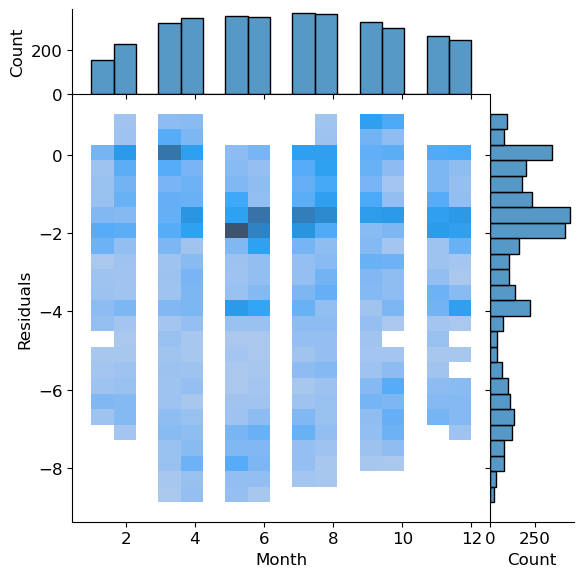

In [16]:
sns.jointplot(data=df, x='Month', y='Residuals', kind='hist', space=0, marginal_ticks=True)

Text(0.5, 1.0, 'Model Residuals by Month')

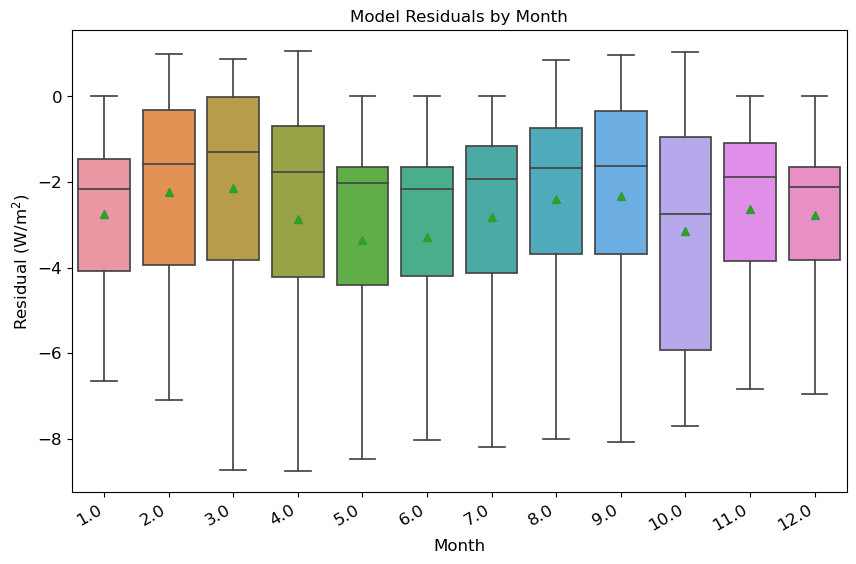

In [17]:
sns.boxplot(data=df, x='Month', y='Residuals', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Residual (W/m$^2$)')
plt.title('Model Residuals by Month')

Text(0.5, 0, 'Solar Azimuth')

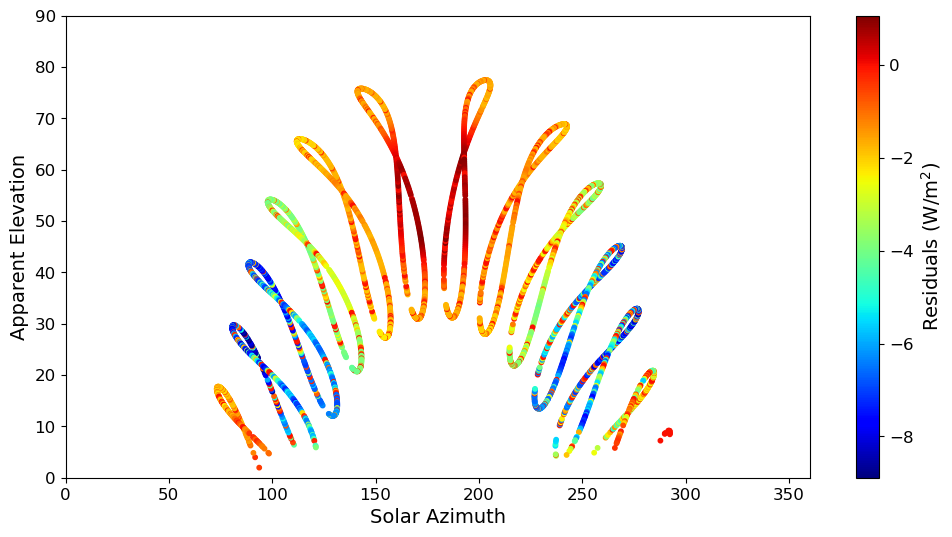

In [18]:
#analemma plots show the residuals at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['resid_trim'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('Residuals (W/m$^2$)',fontsize =14)
# plt.clim(0,(df['resid_trim'].describe()['75%'] + df['resid_trim'].describe()['std']))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)

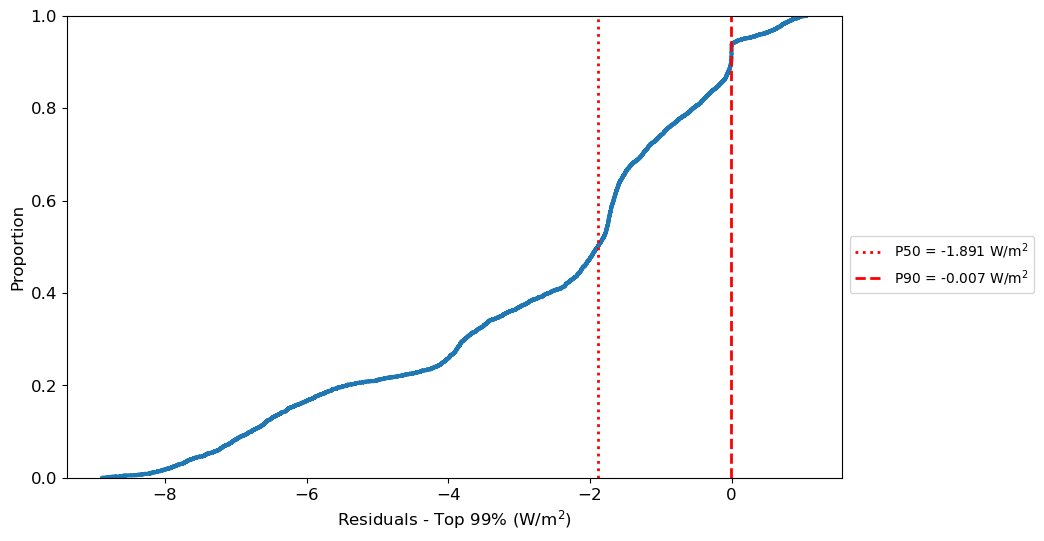

In [19]:
#plot empirical cumulative distribution functions
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (W/m$^2$)')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='red',linestyles='dotted')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 90), ymin=0, ymax=1, linewidth=2, color='red',linestyles='--')


line_2 = Line2D([0], [0], color='red', linewidth=2, linestyle='dotted',label=('P50 = '+str(round(np.percentile(df['resid_trim'].dropna(), 50),3))+' W/m$^2$'))
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('P90 = '+str(round(np.percentile(df['resid_trim'].dropna(), 90),3))+' W/m$^2$'))

lines = [line_2,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)

Text(0.5, 1.0, 'ECDF of Model at High and Low Clearness Index levels')

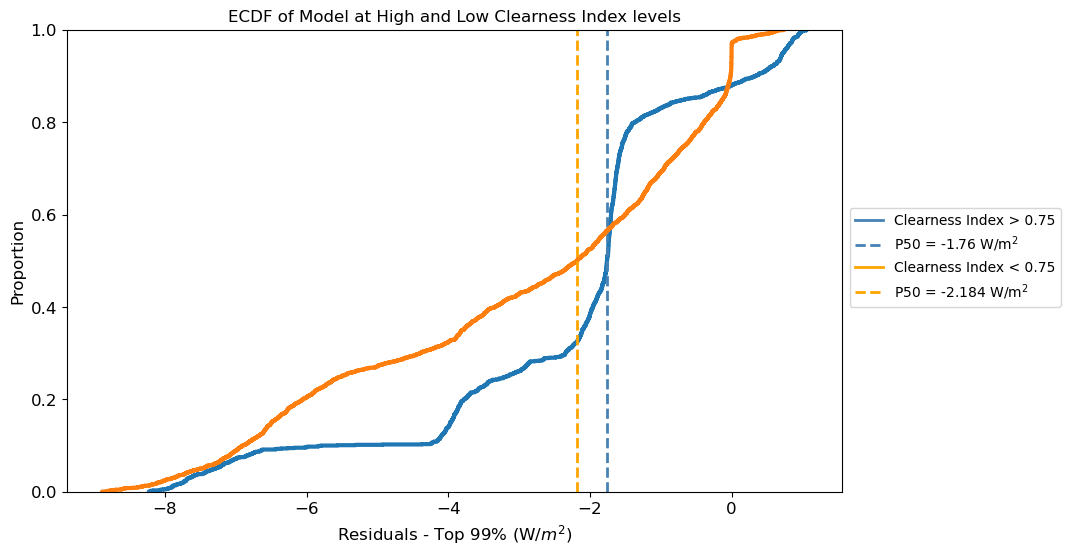

In [20]:
#plotting the ecdf of two groups, determined by the specified metric & boundary
#metric must be a column in the df
metric = 'Clearness Index' #other options could be clearness index, month, etc
#bound dictates how it gets split into lower and higher groups
bound = 0.75

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

sns.ecdfplot(data=df_h, x='resid_trim', linewidth=3)
plt.vlines(x=np.percentile(df_h['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='steelblue',linestyles='dashed')
sns.ecdfplot(data=df_l, x='resid_trim', linewidth=3)
plt.vlines(x=np.percentile(df_l['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='orange',linestyles='dashed')


plt.xlabel('Residuals - Top 99% (W/$m^2$)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_2 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df_h['resid_trim'].dropna(), 50),3))+' W/m$^2$'))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
line_4 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df_l['resid_trim'].dropna(), 50),3))+' W/m$^2$'))

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model at High and Low '+metric+' levels')

## Analysis III: Comparison to Baseline Models
#### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models
In this analysis, the selected baseline model is the Haydavies model

In [21]:
baseline_model = 'ASHRAE'
df['Baseline Model IAM'] = pvlib.iam.ashrae(aoi = df['AOI'])
#calcualte effective irradiance with the baseline iams
df['Effective Irradiance - Baseline'] = ((efdf['poa_direct'] *  (df['Baseline Model IAM'])) + efdf['poa_diffuse'])
#calculate some basic error metrics using that baseline effective irradiance
df['Baseline Residuals'] = df['Effective Irradiance - Baseline'] - df['Effective Irradiance - Interp']
df['Eff Irr - Baseline NBE'] = 100 * (df['Effective Irradiance - Baseline']-df['Effective Irradiance - Interp'])/df['Effective Irradiance - Interp']

In [23]:
#using modeled POA to estimate energy
df['DC Power - Baseline Model IAM'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance - Baseline'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Modeled IAM'], deltaT=3),
                                    pdc0=module['Pmp'], gamma_pdc=module['Gamma Pmp'])
#find overall % diff for annual energy
print('With initial model IAM, predicted annual energy is', round(df['DC Power - Model IAM'].sum()/1000,3),
      'kWh and with baseline modeled IAM, predicted annual energy is', round(df['DC Power - Baseline Model IAM'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using baseline vs modeled IAM is ', round(((df['DC Power - Baseline Model IAM'].sum()-df['DC Power - Model IAM'].sum())/df['DC Power - Model IAM'].sum())*100,3),'%')

With initial model IAM, predicted annual energy is 6625.355 kWh and with baseline modeled IAM, predicted annual energy is 6689.169 kWh
The % difference in energy estimate when using baseline vs modeled IAM is  0.963 %


Text(0.5, 1.0, 'Overall NMBE for Model & Baseline Model')

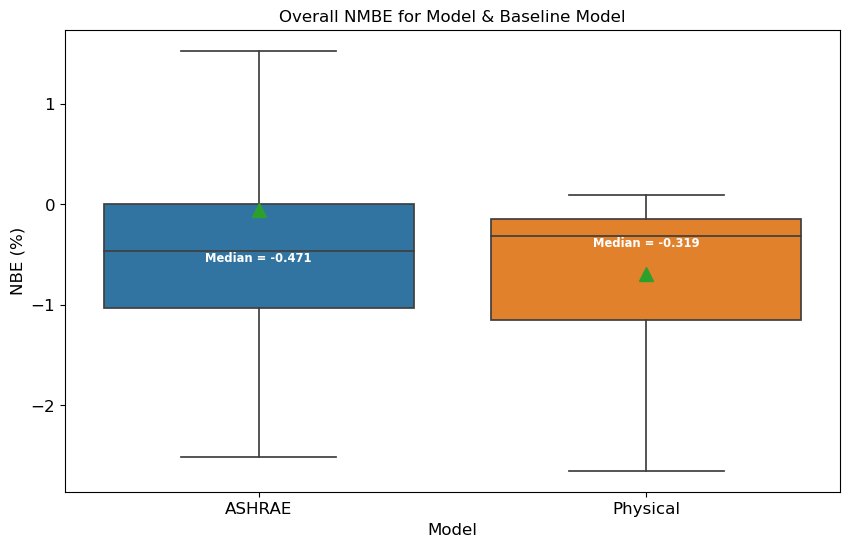

In [24]:
nbe = []
iam_b = 100 * ((df['Effective Irradiance - Baseline'] - df['Effective Irradiance - Interp'])/(df['Effective Irradiance - Interp'])).to_frame()
iam_b.rename(columns = {0 : 'NBE'}, inplace = True)
iam_b['Model'] = 'ASHRAE'
nbe.append(iam_b)
test =  100 * ((df['Effective Irradiance - Model IAM'] - df['Effective Irradiance - Interp'])/(df['Effective Irradiance - Interp'])).to_frame()
test.rename(columns = {0 : 'NBE'}, inplace = True)
test['Model'] = 'Physical'
nbe.append(test)
nbe_df = pd.concat(nbe, ignore_index=True)
box_plot = sns.boxplot(x='Model', y='NBE', data=nbe_df, showfliers=False, showmeans=True, meanprops={'markersize':10})
plt.ylabel('NBE (%)')
medians = nbe_df.groupby(['Model'])['NBE'].median()
vertical_offset = nbe_df['NBE'].median() * 0.25 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,('Median = '+str(round(medians[xtick],3))),horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.title('Overall NMBE for Model & Baseline Model')

Text(0.5, 1.0, 'ECDF of Model & Baseline Model Residuals')

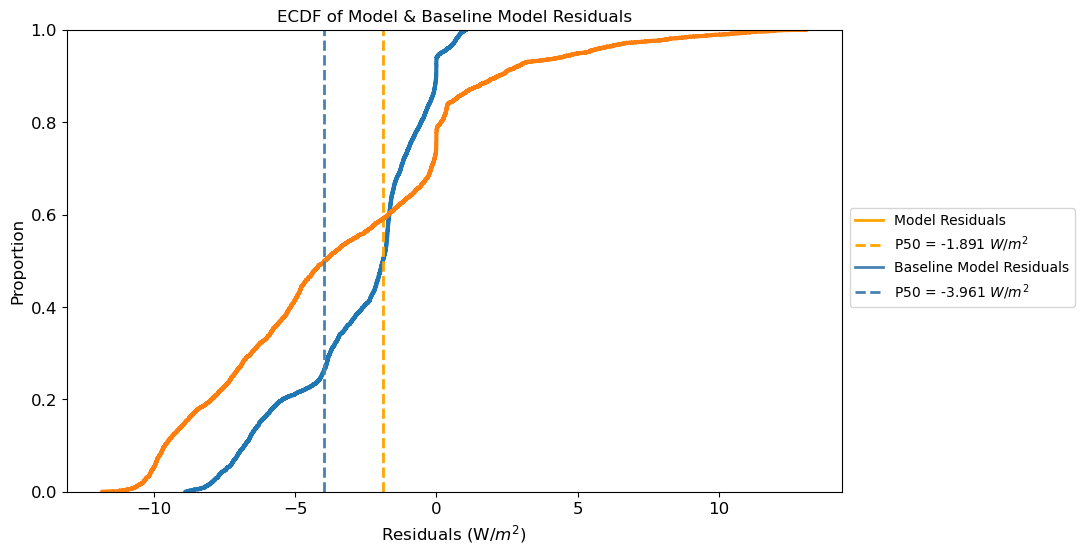

In [25]:
#ecdf of the two models overlayed & p50 given
sns.ecdfplot(data=df, x='Residuals', linewidth=3)
plt.vlines(x=np.percentile(df['Residuals'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='orange',linestyles='dashed')
sns.ecdfplot(data=df, x='Baseline Residuals',linewidth=3)
plt.vlines(x=np.percentile(df['Baseline Residuals'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='steelblue',linestyles='dashed')


plt.xlabel('Residuals (W/$m^2$)')
line_1 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Model Residuals')
line_2 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=('P50 ='+' '+str(round(np.percentile(df['Residuals'].dropna(), 50),3))+' $W/m^2$'))
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Baseline Model Residuals')
line_4 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=('P50 ='+' '+str(round(np.percentile(df['Baseline Residuals'].dropna(), 50),3))+' $W/m^2$'))

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model & Baseline Model Residuals')

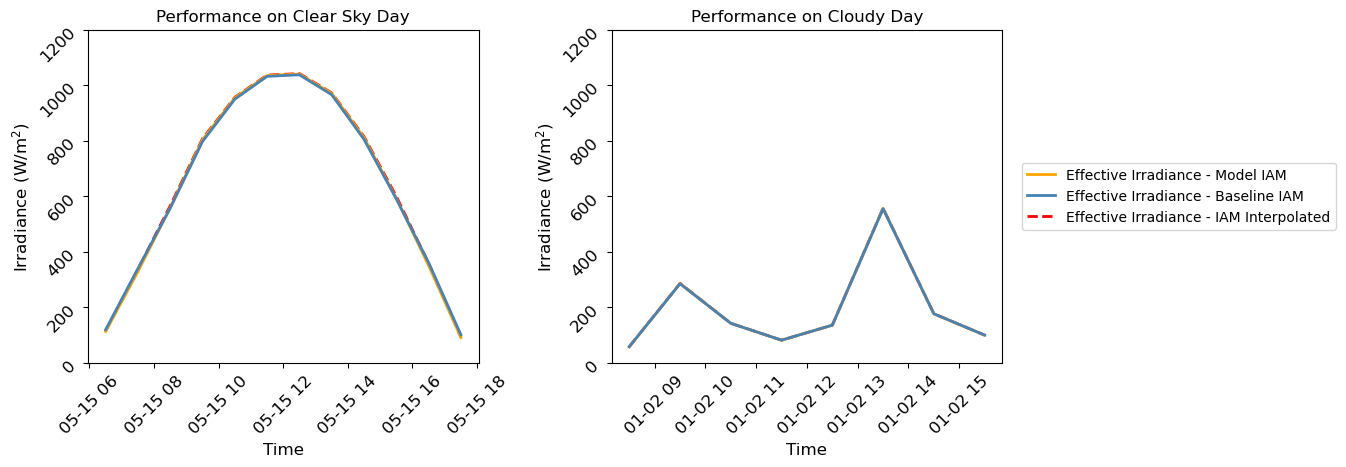

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.tight_layout(w_pad = 5)

#diurnal plot for clearsky day
day = 15
month = 5
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Effective Irradiance - Interp'], linewidth=2, linestyle = 'dashed',color='red', zorder=5.5)
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Effective Irradiance - Model IAM'], linewidth=2, color='orange', zorder=5.5)
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Effective Irradiance - Baseline'], linewidth=2, color='steelblue', zorder=5.5)

ax1.tick_params(labelrotation = 45)
ax1.set_ylabel('Irradiance (W/m$^2$)')
ax1.set_xlabel('Time')
ax1.set_ylim(0,1200)

plt.grid(False)

ax1.patch.set_visible(False)
ax1.set_title('Performance on Clear Sky Day')


#diurnal plot for cloudy day
day = 2
month = 1
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Effective Irradiance - Interp'], linewidth=2, linestyle = 'dashed', color='red', zorder=5.5)
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Effective Irradiance - Model IAM'], linewidth=2, color='orange', zorder=5.5)
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Effective Irradiance - Baseline'], linewidth=2, color='steelblue', zorder=5.5)

ax2.tick_params(labelrotation = 45)
ax2.set_ylabel('Irradiance (W/m$^2$)')
ax2.set_xlabel('Time')
ax2.set_ylim(0,1200)

plt.grid(False)

ax2.patch.set_visible(False)
ax2.set_title('Performance on Cloudy Day')

line_1 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Effective Irradiance - Model IAM')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Effective Irradiance - Baseline IAM')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='Effective Irradiance - IAM Interpolated')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.05, 0.4],handles=lines)



Text(0.5, 1.0, 'NMBE (%) of models in different irradiance bins')

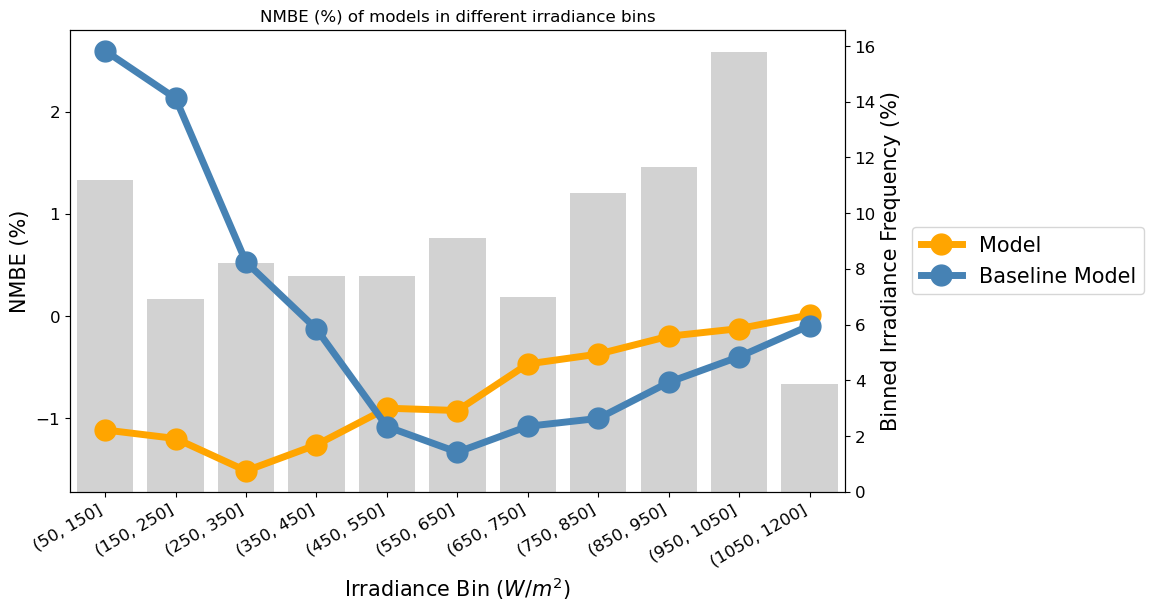

In [27]:
#plotting the model's NMBE at different irradiance levels
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df.groupby('Irradiance Bins').mean()['Eff Irr - Model IAM NBE']
ax.plot(x, y, 'orange', marker='o', zorder=6.5, linewidth=5, markersize=15)
y = df.groupby('Irradiance Bins').mean()['Eff Irr - Baseline NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=5, markersize=15)
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('NMBE (%)', fontsize=15)
ax.set_xlabel('Irradiance Bin ($W/m^2$)', fontsize=15)
ax.legend(['Model','Baseline Model'],loc='center right',bbox_to_anchor=(1.4, 0.5), fontsize=15)

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
plt.title('NMBE (%) of models in different irradiance bins')